In [107]:
# import library
import librosa
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import os
from datetime import datetime 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# Inputs

In [108]:
# TRAINED MODEL
# model folder
MODEL_FP = 'models/'

# SAMPLE DATA
# audio file path
SAMPLE_AUDIO_FP = 'audio_sample/'

# sample audio spreadsheet name
SAMPLE_AUDIO_FN = 'list_of_sample_audio.xlsx'

# Load stored preprocessed data 

In [109]:
%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
%store -r y2
%store -r LabelEncoder

In [110]:
x_train

array([[ -92.15989   ,  129.1144    ,  -34.144245  , ...,    2.5986712 ,
           0.74938154,    3.6659362 ],
       [-317.44446   ,  140.85509   ,   -4.442789  , ...,   -6.1748104 ,
          -2.4074438 ,    1.9058033 ],
       [-158.85657   ,  106.16268   ,  -16.495901  , ...,    2.3946655 ,
          -0.7011692 ,    1.7082653 ],
       ...,
       [-151.8832    ,   95.09373   ,  -55.13047   , ...,  -24.268118  ,
         -15.198542  ,   19.769062  ],
       [-368.56152   ,  173.54724   ,  -18.311768  , ...,   -4.0129285 ,
          -1.5358983 ,   -2.6071749 ],
       [-213.24379   ,  139.36234   ,  -20.374676  , ...,   -3.2454274 ,
          -0.83539003,    1.7700078 ]], dtype=float32)

In [111]:
# input shapes
x_train.shape

(6985, 40)

In [112]:
y_train.shape

(6985, 10)

In [113]:
# total number of class
tot_class = y2.shape[1]

# total inputs
tot_input = x_train.shape[1]

# Functions
Customize functions

In [142]:
# function used to extract feature from sample audio
def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    return np.array([mfccsscaled])

In [143]:
# function to plot confusion matrix
# code source: https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Model architecture: MLP
Construct a Multilayer perceptron (MLP) Neural Network using Keras and Tensorflow

In [114]:
# Construct model and build layer by layer
model = Sequential()

Begin with simple model architecture, which consists of 3 layers:
- Input layer
- Hidden layer
- Output layer


All 3 layers will be "dense" layer type which is the standard layer type in NN.

Architecture structure:
1. **First layer:** receive input shape. Each audio contains 40 MFCCs (columns)
2. **First 2 layer:** 256 nodes, and dropout 50%. Dropout will randomly exclude nodes from each update cycle which resulting in a network have better generalisation and less likely to overfit the training data.
3. **First 2 layer Activation function**: relu (Rectified Linear Activation), proven to have work well in NN.
4. **Output layer:** 10 nodes (total classes).
5. **Output layer activation:** softmax. This makes the output sum up to 1 so the output can be innterpreted as probabilities. The model will make its prediction  based on which option has the highest probability.

In [115]:
# model architecture
model.add(Dense(256, input_shape=(tot_input,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(tot_class))
model.add(Activation('softmax'))

# Compile the model
Use the following 3 parameters to compile the model:
- Loss function: "Categorical crossentropy". Most common choice for classification. Low score = model is performing better.
- Metrics: "accuracy". Allow to view accuracy score to validate the data.
- Optimizer: "adam", common and generally good optimizer.

In [116]:
# Compile the model
model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'], 
              optimizer='adam') 

In [117]:
# Display the model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [118]:
# show pre-training accuracy
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100 * score[1]
print("Pre-training accuracy: %.4f%%" % accuracy)

Pre-training accuracy: 7.5558%


# Train the model
Train the model.

- Start with 100 epoch (number of times the model will cycle through the data).
- Start with 32 batch size. Large batch size can reduce the generalisation ability of the model


In [119]:
# inputs
NUM_EPOCH = 100
NUM_BATCH = 32

# model name
MODEL_NAME = 'mlp_basic_model.hdf5'

checkpointer = ModelCheckpoint(filepath= MODEL_FP + MODEL_NAME, 
                               verbose=1, save_best_only=True)

# begin training
starttime = datetime.now()

# train the model
model.fit(x_train, 
          y_train, 
          batch_size=NUM_BATCH, 
          epochs=NUM_EPOCH, 
          validation_data=(x_test, y_test), 
          callbacks=[checkpointer], verbose=1)

duration = datetime.now() - starttime
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 1s 80us/step - loss: 8.7573 - accuracy: 0.1914 - val_loss: 2.1725 - val_accuracy: 0.1597

Epoch 00001: val_loss improved from inf to 2.17254, saving model to models/mlp_basic_model.hdf5
Epoch 2/100
6985/6985 [==============================] - 0s 71us/step - loss: 2.2972 - accuracy: 0.2213 - val_loss: 2.0992 - val_accuracy: 0.2438

Epoch 00002: val_loss improved from 2.17254 to 2.09923, saving model to models/mlp_basic_model.hdf5
Epoch 3/100
6985/6985 [==============================] - 0s 66us/step - loss: 2.0637 - accuracy: 0.2746 - val_loss: 1.8808 - val_accuracy: 0.3589

Epoch 00003: val_loss improved from 2.09923 to 1.88076, saving model to models/mlp_basic_model.hdf5
Epoch 4/100
6985/6985 [==============================] - 0s 64us/step - loss: 1.9195 - accuracy: 0.3137 - val_loss: 1.7280 - val_accuracy: 0.4093

Epoch 00004: val_loss improved from 1.88076 to 1.72798, saving model


Epoch 00034: val_loss did not improve from 0.60439
Epoch 35/100
6985/6985 [==============================] - 0s 61us/step - loss: 0.7269 - accuracy: 0.7549 - val_loss: 0.5925 - val_accuracy: 0.8237

Epoch 00035: val_loss improved from 0.60439 to 0.59251, saving model to models/mlp_basic_model.hdf5
Epoch 36/100
6985/6985 [==============================] - 0s 62us/step - loss: 0.6958 - accuracy: 0.7672 - val_loss: 0.5810 - val_accuracy: 0.8197

Epoch 00036: val_loss improved from 0.59251 to 0.58102, saving model to models/mlp_basic_model.hdf5
Epoch 37/100
6985/6985 [==============================] - 0s 65us/step - loss: 0.6991 - accuracy: 0.7655 - val_loss: 0.5702 - val_accuracy: 0.8260

Epoch 00037: val_loss improved from 0.58102 to 0.57022, saving model to models/mlp_basic_model.hdf5
Epoch 38/100
6985/6985 [==============================] - 0s 66us/step - loss: 0.6881 - accuracy: 0.7664 - val_loss: 0.5557 - val_accuracy: 0.8306

Epoch 00038: val_loss improved from 0.57022 to 0.55572, 

6985/6985 [==============================] - 0s 69us/step - loss: 0.5436 - accuracy: 0.8105 - val_loss: 0.4562 - val_accuracy: 0.8695

Epoch 00072: val_loss improved from 0.45815 to 0.45616, saving model to models/mlp_basic_model.hdf5
Epoch 73/100
6985/6985 [==============================] - 1s 91us/step - loss: 0.5521 - accuracy: 0.8190 - val_loss: 0.4634 - val_accuracy: 0.8626

Epoch 00073: val_loss did not improve from 0.45616
Epoch 74/100
6985/6985 [==============================] - 1s 75us/step - loss: 0.5477 - accuracy: 0.8179 - val_loss: 0.4599 - val_accuracy: 0.8603

Epoch 00074: val_loss did not improve from 0.45616
Epoch 75/100
6985/6985 [==============================] - 0s 65us/step - loss: 0.5373 - accuracy: 0.8137 - val_loss: 0.4692 - val_accuracy: 0.8695

Epoch 00075: val_loss did not improve from 0.45616
Epoch 76/100
6985/6985 [==============================] - 0s 61us/step - loss: 0.5301 - accuracy: 0.8185 - val_loss: 0.4611 - val_accuracy: 0.8695

Epoch 00076: val_los

# Test the model

In [144]:
# test with testing data
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100 * score[1]
print("Trained model on testing sets accuracy: %.4f%%" % accuracy)

Trained model on testing sets accuracy: 87.3497%


In [145]:
# test with training data
score = model.evaluate(x_train, y_train, verbose=0)
accuracy = 100 * score[1]
print("Trained model on training sets accuracy: %.4f%%" % accuracy)

Trained model on training sets accuracy: 92.8848%


[Observations]
- Pre-training model accuracy is 11%.
- Trained model accuracy is 87%.
- Training sets accuracy is > testing sets accuracy, this indicate that the model has not suffered from overfitting

### Confusion Matrix and Classification Report

In [122]:
# predict the test data using the model
predictions = model.predict(x_test)

In [123]:
# convert array into vector (classes in number)

# get the selected classses in testing data set
val_test = np.zeros((y_test.shape[0],1))
for i in range(val_test.shape[0]):

    # for CATEGORICAL: pick the highest confidence value
    val_test[i] = np.argmax(y_test[i])

# get the predicted classes
val_preds = np.zeros((predictions.shape[0],1))
for i in range(predictions.shape[0]):

    # for CATEGORICAL: pick the highest confidence value
    val_preds[i] = np.argmax(predictions[i])
    

In [124]:
# snippet of predicted class
val_preds

array([[9.],
       [3.],
       [8.],
       ...,
       [4.],
       [7.],
       [3.]])

In [126]:
# define classes
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music
    
class_label = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
          'drilling', 'engine_idling', 'gun_shot', 'jackhammer',
          'siren', 'street_music']

In [127]:
# Evaluate the model: using classification report and confusion matrix
# using classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# show classification report
print(classification_report(val_test, val_preds))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       192
         1.0       0.94      0.88      0.91        77
         2.0       0.68      0.83      0.75       202
         3.0       0.89      0.75      0.81       219
         4.0       0.92      0.91      0.92       185
         5.0       0.96      0.95      0.96       206
         6.0       0.91      0.68      0.78        63
         7.0       0.94      0.96      0.95       196
         8.0       0.97      0.91      0.94       191
         9.0       0.74      0.83      0.78       216

   micro avg       0.87      0.87      0.87      1747
   macro avg       0.89      0.86      0.87      1747
weighted avg       0.88      0.87      0.88      1747



Confusion matrix, without normalization
[[178   0   8   0   0   0   0   0   0   6]
 [  0  68   1   0   0   0   0   3   0   5]
 [  5   2 168   4   3   2   0   3   0  15]
 [  0   0  25 164   3   1   4   0   3  19]
 [  0   0   1   2 168   1   0   5   0   8]
 [  1   0   1   1   0 196   0   0   2   5]
 [  0   1   9   9   0   0  43   0   0   1]
 [  1   0   1   0   4   0   0 188   0   2]
 [  0   0   7   3   2   2   0   0 174   3]
 [  2   1  25   2   2   2   0   2   1 179]]


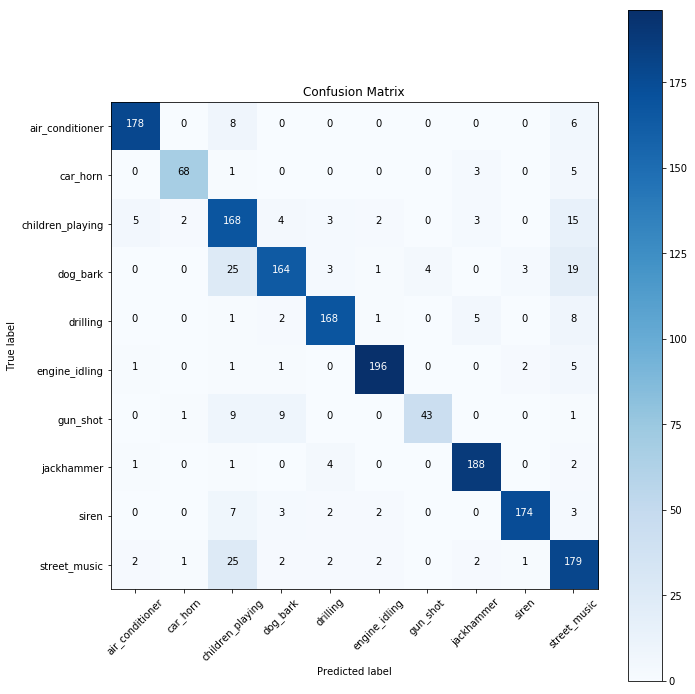

In [128]:
# show confusion matrix
# confusion_matrix(y_true, y_pred)
cm = confusion_matrix(val_test, val_preds)

# plot confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm=cm, classes=class_label, title='Confusion Matrix' )

# Test the model with sample audio

In [129]:
# load sample audio
list_audio = pd.read_excel(SAMPLE_AUDIO_FP + SAMPLE_AUDIO_FN)
list_audio

,slice_file_name,fsID,start,end,salience,fold,classID,class_name
0,100852-0-0-0.wav,100852,0.000000,4.000000,1,5,0,air_conditioner
1,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn
2,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
3,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
4,103199-4-0-0.wav,103199,0.000000,4.000000,1,3,4,drilling
5,102857-5-0-0.wav,102857,0.000000,4.000000,1,10,5,engine_idling
6,102305-6-0-0.wav,102305,0.000000,2.611610,1,1,6,gun_shot
7,103074-7-0-0.wav,103074,3.341279,7.341279,1,1,7,jackhammer
8,102853-8-0-0.wav,102853,0.000000,4.000000,2,7,8,siren
9,101848-9-0-0.wav,101848,0.000000,4.000000,1,7,9,street_music


The original class is: air_conditioner
The predicted class is: air_conditioner 



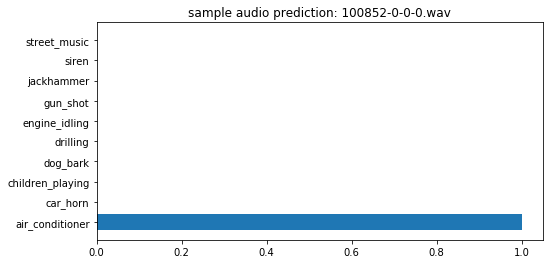



The original class is: car_horn
The predicted class is: car_horn 



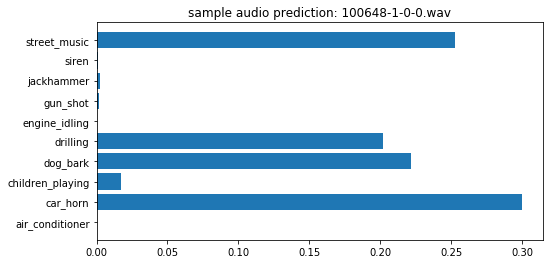



The original class is: children_playing
The predicted class is: children_playing 



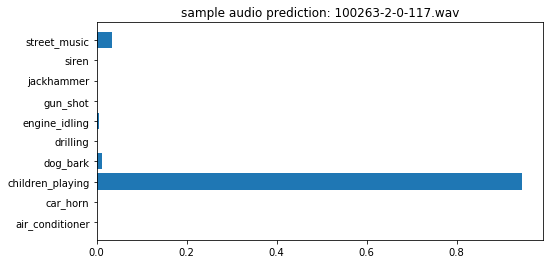



The original class is: dog_bark
The predicted class is: dog_bark 



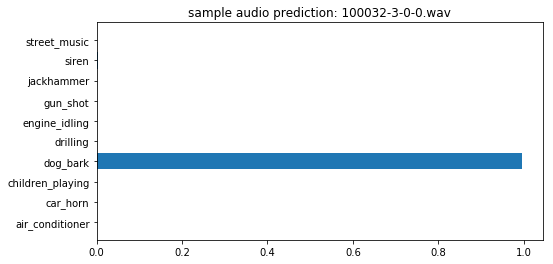



The original class is: drilling
The predicted class is: drilling 



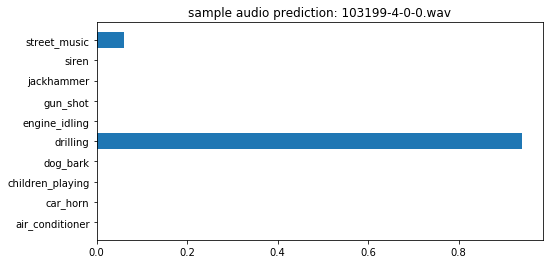



The original class is: engine_idling
The predicted class is: engine_idling 



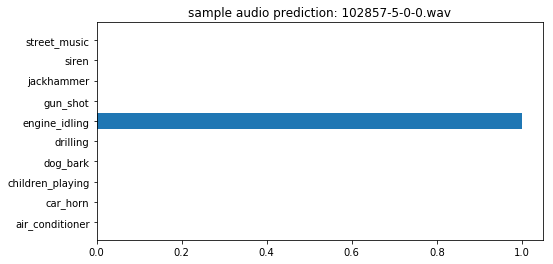



The original class is: gun_shot
The predicted class is: children_playing 



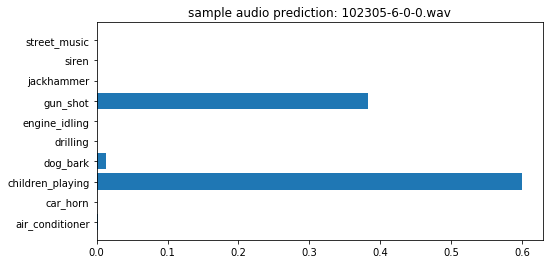



The original class is: jackhammer
The predicted class is: jackhammer 



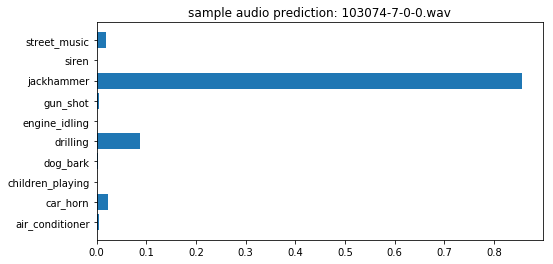



The original class is: siren
The predicted class is: siren 



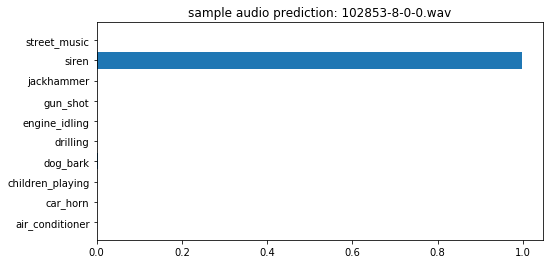



The original class is: street_music
The predicted class is: street_music 



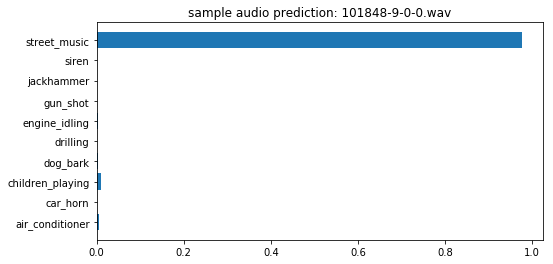

In [140]:
# test all sample audio with the model
for i, row in list_audio.iterrows():
    classname = row['class_name']
    audiofile = row['slice_file_name']
    
    # audio full file name
    audio_ffn = SAMPLE_AUDIO_FP + audiofile
    
    # feature
    feature = extract_feature(audio_ffn)
    
    # predicted class
    pred_vector = model.predict_classes(feature)
    pred_class = LabelEncoder.inverse_transform(pred_vector) 
    
    # all class prediction probability
    pred_prob_vector = model.predict_proba(feature)
    pred_prob_class = pred_prob_vector[0]
    
    # print out results
    print("The original class is:", classname)
    print("The predicted class is:", pred_class[0], '\n')  
    
    # display all predict probability
    #for i in range(len(pred_prob_class)): 
    #    category = LabelEncoder.inverse_transform(np.array([i]))
    #    print("{:.2%}".format(pred_prob_class[i]), category[0] )
    
    # display all predict probability
    plt.figure(figsize=(8,4))
    plt.barh(class_label, pred_prob_class)
    plt.title("sample audio prediction: {}".format(audiofile))
    plt.show()
    
    print('\n')
